<a href="https://colab.research.google.com/github/ninnafil/ExtraTreesClassifier_LinearSVC/blob/main/ExtraTreesClassifier_LinearSVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [209]:
!pip install phik

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [211]:
# Загрузка датасета
df = pd.read_csv('global_house_purchase_dataset.csv')

# Исследование датасета и первичный анализ данных
print(df.head())
print(df.info())
print(df.isnull().sum())

   property_id       country          city property_type furnishing_status  \
0            1        France     Marseille     Farmhouse    Semi-Furnished   
1            2  South Africa     Cape Town     Apartment    Semi-Furnished   
2            3  South Africa  Johannesburg     Farmhouse    Semi-Furnished   
3            4       Germany     Frankfurt     Farmhouse    Semi-Furnished   
4            5  South Africa  Johannesburg     Townhouse   Fully-Furnished   

   property_size_sqft    price  constructed_year  previous_owners  rooms  ...  \
0                 991   412935              1989                6      6  ...   
1                1244   224538              1990                4      8  ...   
2                4152   745104              2019                5      2  ...   
3                3714  1110959              2008                1      3  ...   
4                 531    99041              2007                6      3  ...   

   customer_salary  loan_amount  loan_tenure

In [212]:
# Удаляем ненужные для анализа столбцы
df.drop(['property_id'], axis = 1, inplace = True)

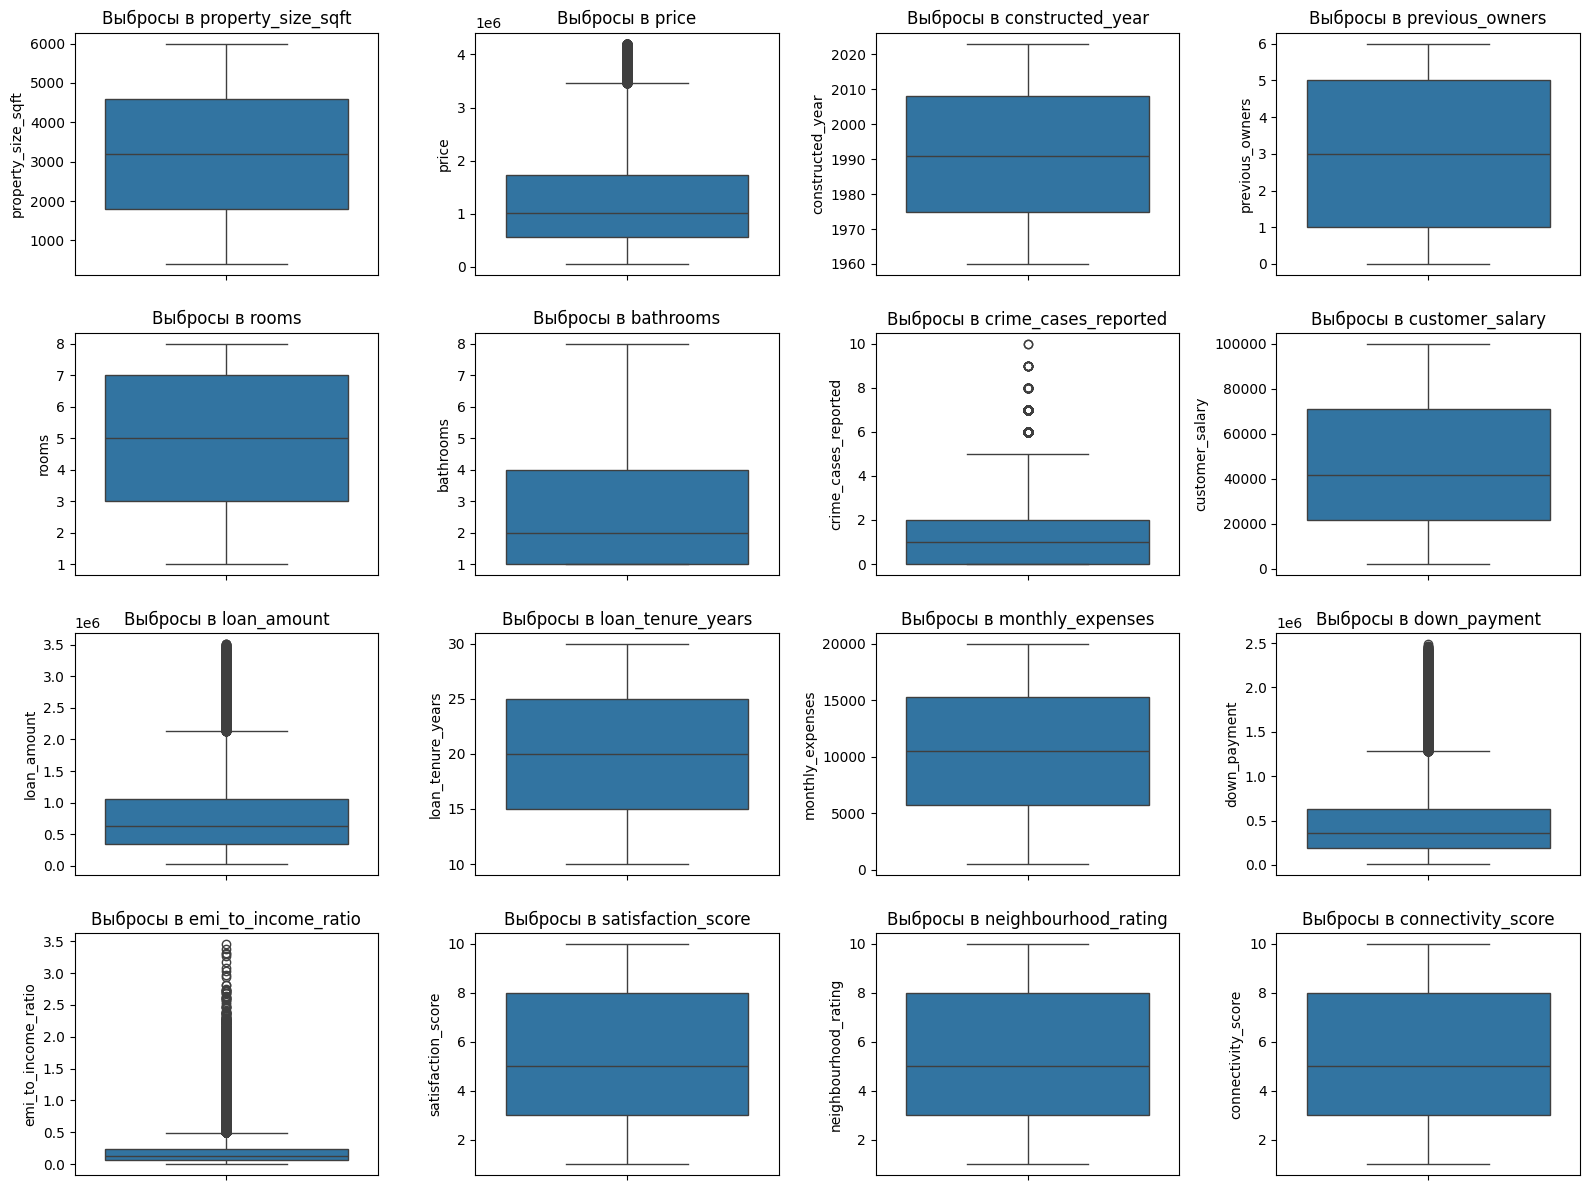

In [213]:
# Выбираем числовые признаки (исключая бинарные) для анализа выбросов
numerical_features = [
    'property_size_sqft', 'price', 'constructed_year', 'previous_owners',
    'rooms', 'bathrooms', 'crime_cases_reported', 'customer_salary',
    'loan_amount', 'loan_tenure_years', 'monthly_expenses', 'down_payment',
    'emi_to_income_ratio', 'satisfaction_score', 'neighbourhood_rating',
    'connectivity_score'
]

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df, y=col, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Выбросы в {col}')
plt.tight_layout()
plt.show()

In [214]:
# Проверка распределения классов
print(df['decision'].value_counts())

decision
0    153932
1     46068
Name: count, dtype: int64


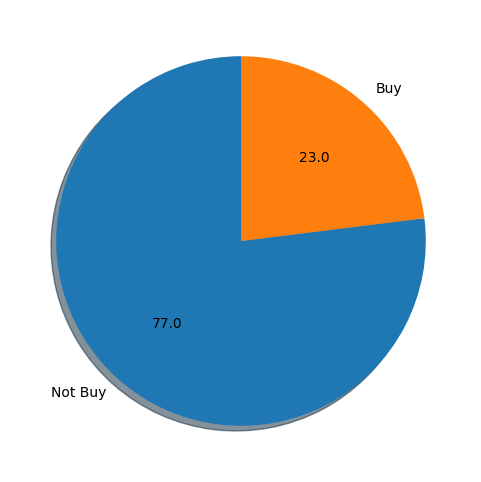

In [215]:
plt.figure(figsize = (6,6))
plt.pie(df['decision'].value_counts(), startangle = 90, autopct = '%.1f', labels = ['Not Buy', 'Buy'], shadow = True)
plt.show()

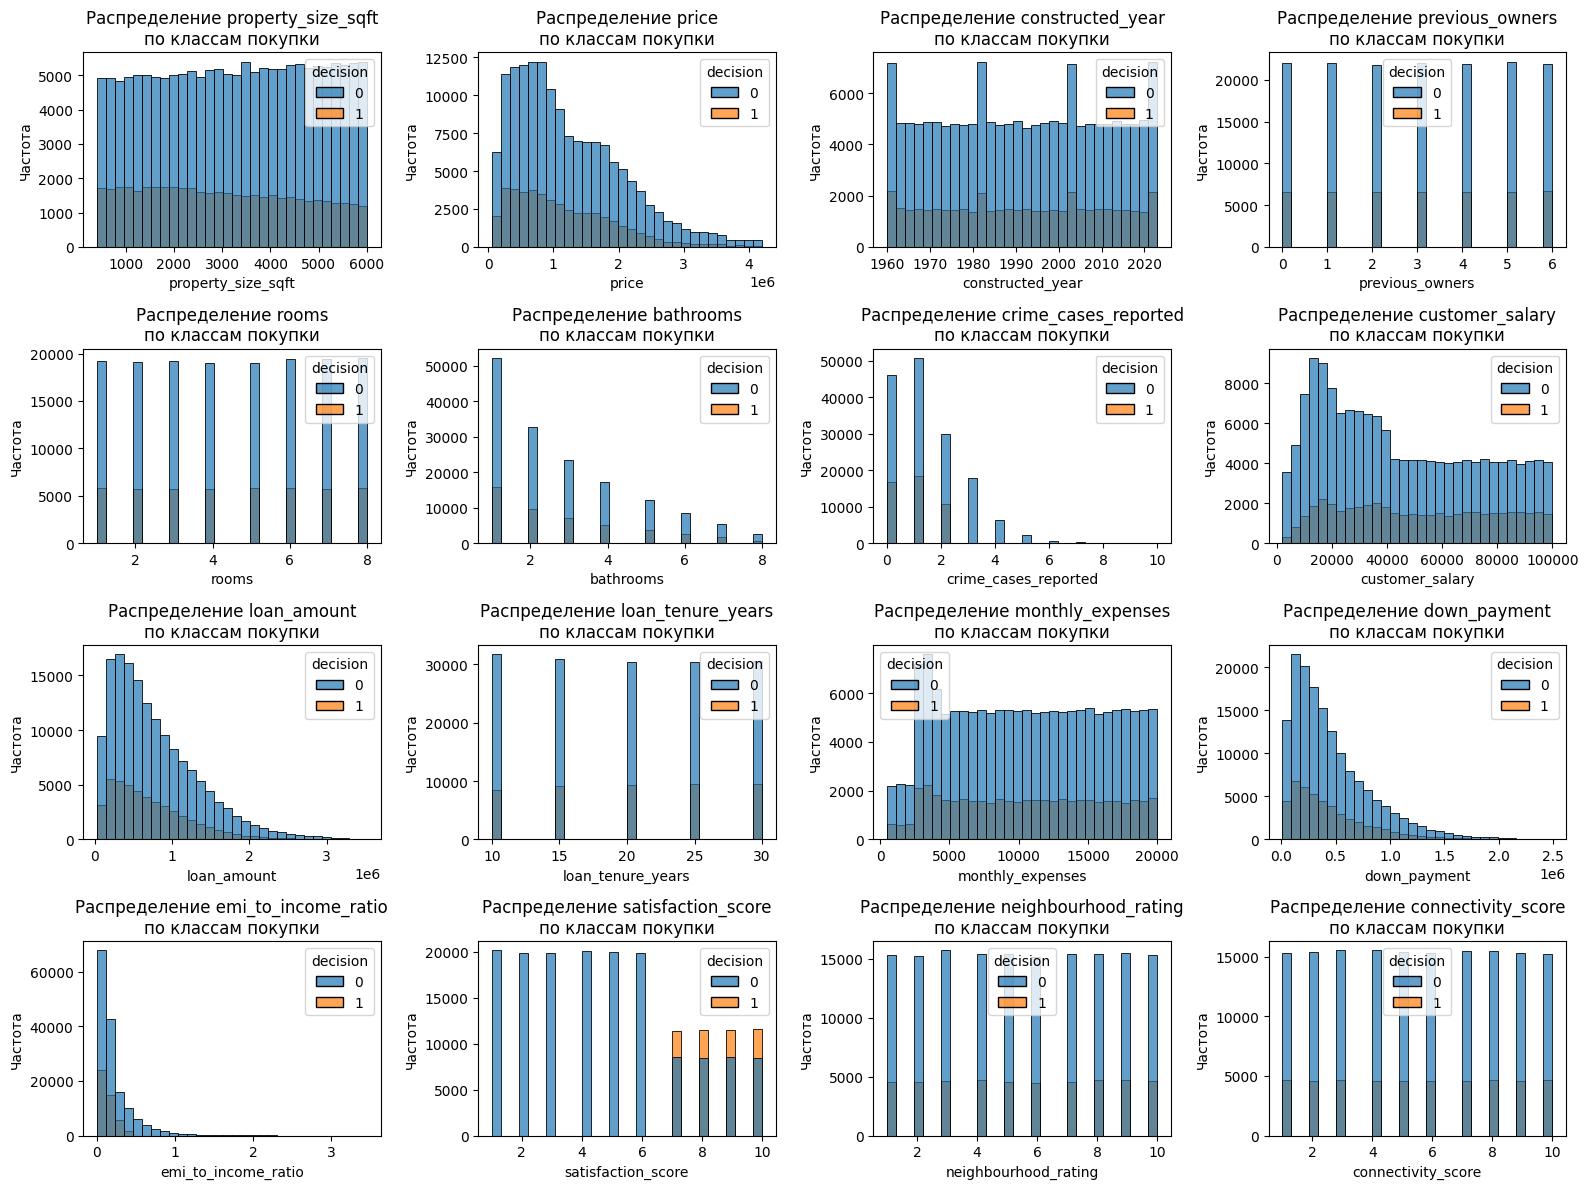

In [216]:
# Визуализация числовых признаков

# Выбираем числовые признаки
numerical_features = [
    'property_size_sqft', 'price', 'constructed_year', 'previous_owners',
    'rooms', 'bathrooms', 'crime_cases_reported', 'customer_salary',
    'loan_amount', 'loan_tenure_years', 'monthly_expenses', 'down_payment',
    'emi_to_income_ratio', 'satisfaction_score', 'neighbourhood_rating',
    'connectivity_score'
]

# Создаем сетку
plt.figure(figsize=(16, 12))

for i, feature in enumerate(numerical_features):
    plt.subplot(4, 4, i+1)  # 4 строки, 4 столбца

    # Гистограммы с разделением по классам
    sns.histplot(data=df, x=feature, hue='decision', bins=30, alpha=0.7)
    plt.title(f'Распределение {feature}\nпо классам покупки')
    plt.xlabel(feature)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

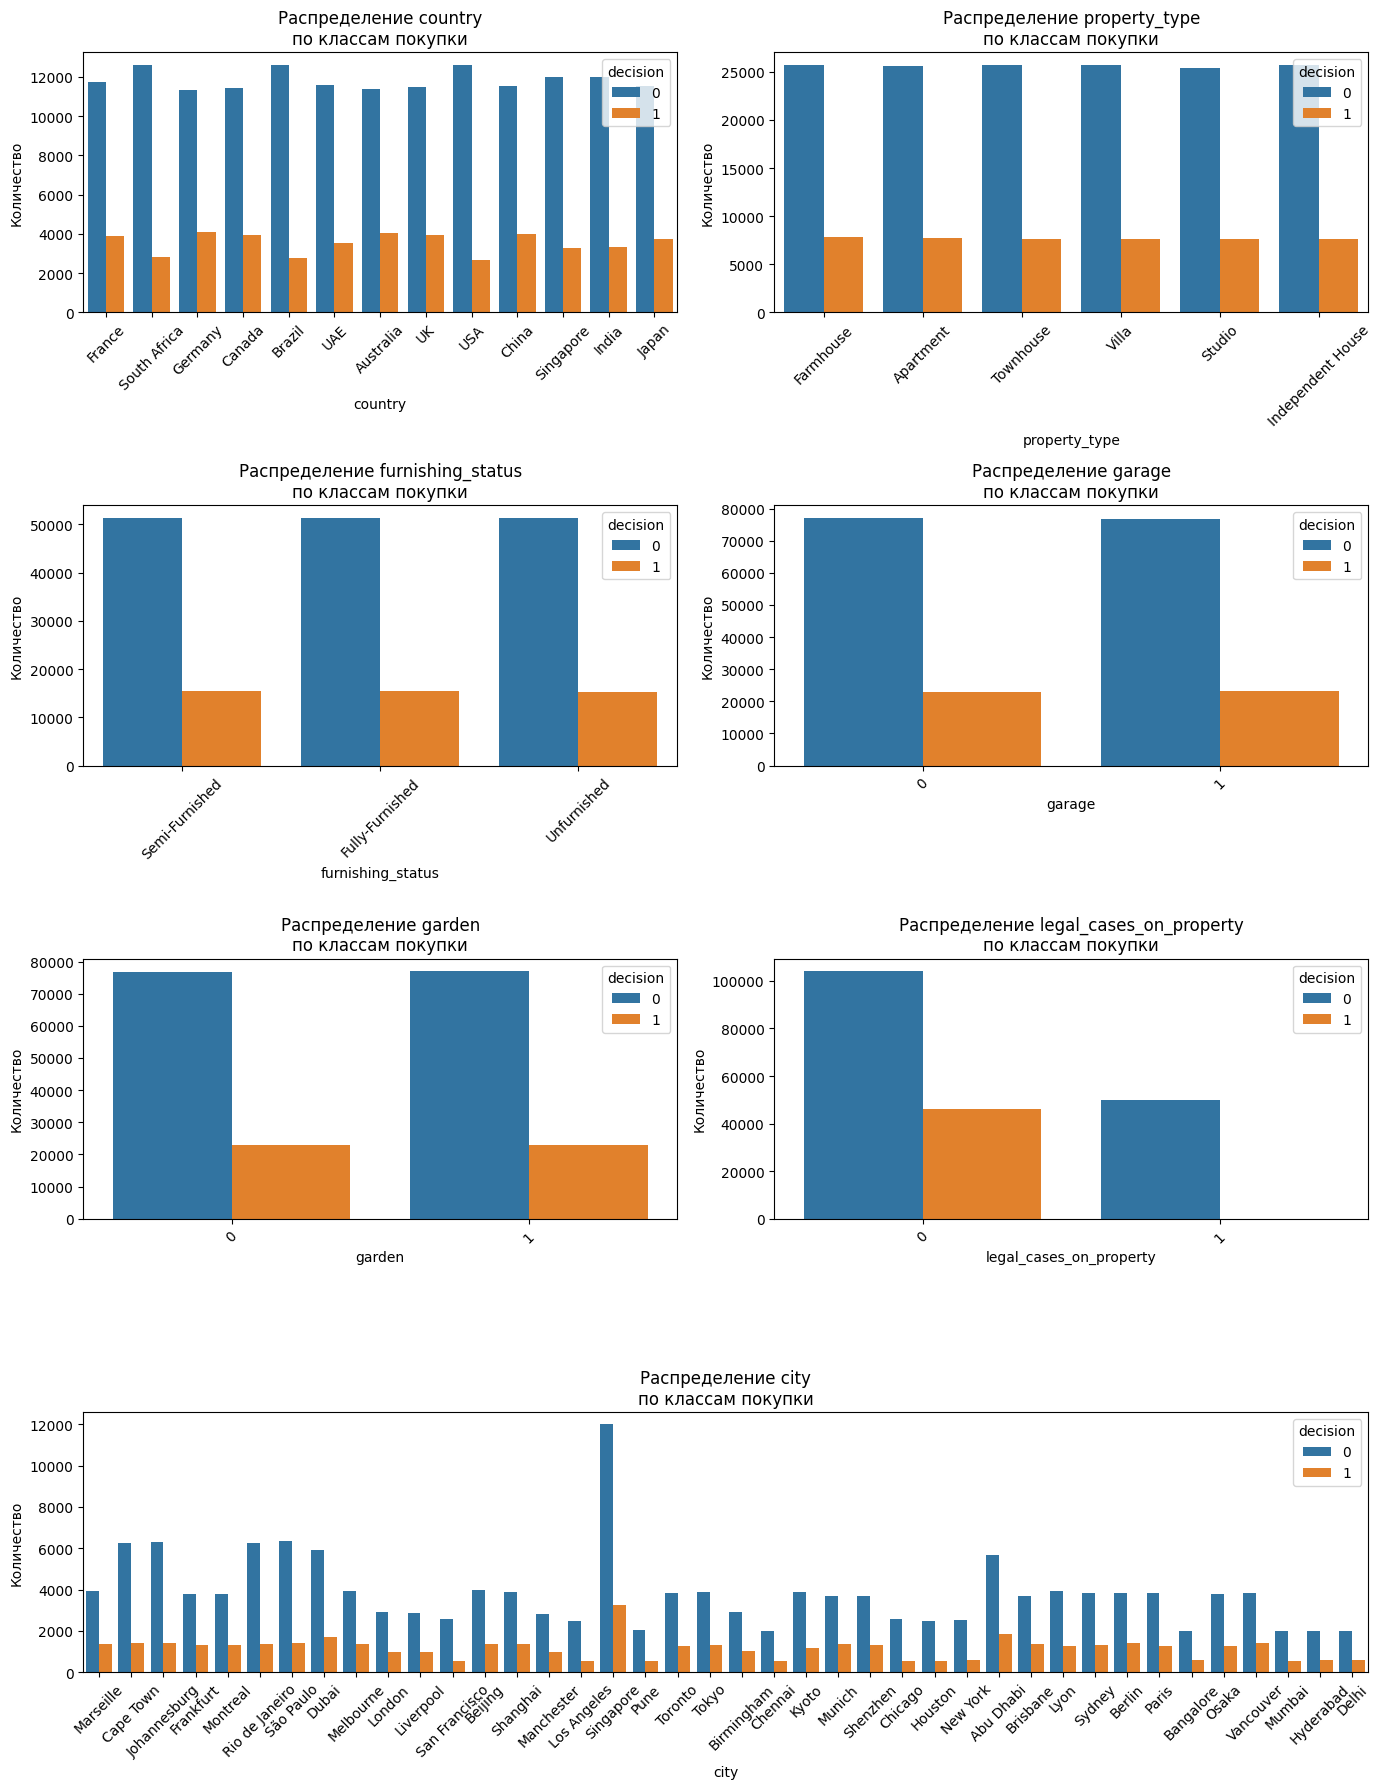

In [217]:
# Визуализация категориальных и бинарных признаков

# Признаки
features = [
    'country', 'property_type', 'furnishing_status',
    'garage', 'garden', 'legal_cases_on_property', 'city',
]

plt.figure(figsize=(14, 18))

# Визуализация первых 6 признаков
for i, feature in enumerate(features[:6]):
    plt.subplot(4, 2, i+1)

    sns.countplot(data=df, x=feature, hue='decision')
    plt.title(f'Распределение {feature}\nпо классам покупки')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

# Последний график растягиваем на последнюю строку
plt.subplot(4, 2, (7, 8))

feature = features[6]
sns.countplot(data=df, x=feature, hue='decision')
plt.title(f'Распределение {feature}\nпо классам покупки')
plt.xlabel(feature)
plt.ylabel('Количество')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [218]:
# Анализ категориальных признаков
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nРаспределение значений в столбце '{col}':")
    value_counts = df[col].value_counts()
    print(value_counts)
    print(f"Количество уникальных значений: {df[col].nunique()}")


Распределение значений в столбце 'country':
country
France          15628
China           15536
Australia       15442
UK              15413
Germany         15408
South Africa    15401
Canada          15401
Brazil          15397
India           15357
Japan           15317
USA             15281
Singapore       15278
UAE             15141
Name: count, dtype: int64
Количество уникальных значений: 13

Распределение значений в столбце 'city':
city
Singapore         15278
São Paulo          7755
Johannesburg       7712
Cape Town          7689
Rio de Janeiro     7642
Dubai              7637
Abu Dhabi          7504
Marseille          5328
Beijing            5328
Melbourne          5289
Berlin             5241
Lyon               5220
Vancouver          5213
Shanghai           5209
Tokyo              5188
Sydney             5142
Frankfurt          5117
Montreal           5112
Paris              5080
Toronto            5076
Kyoto              5075
Osaka              5054
Munich             5050
B

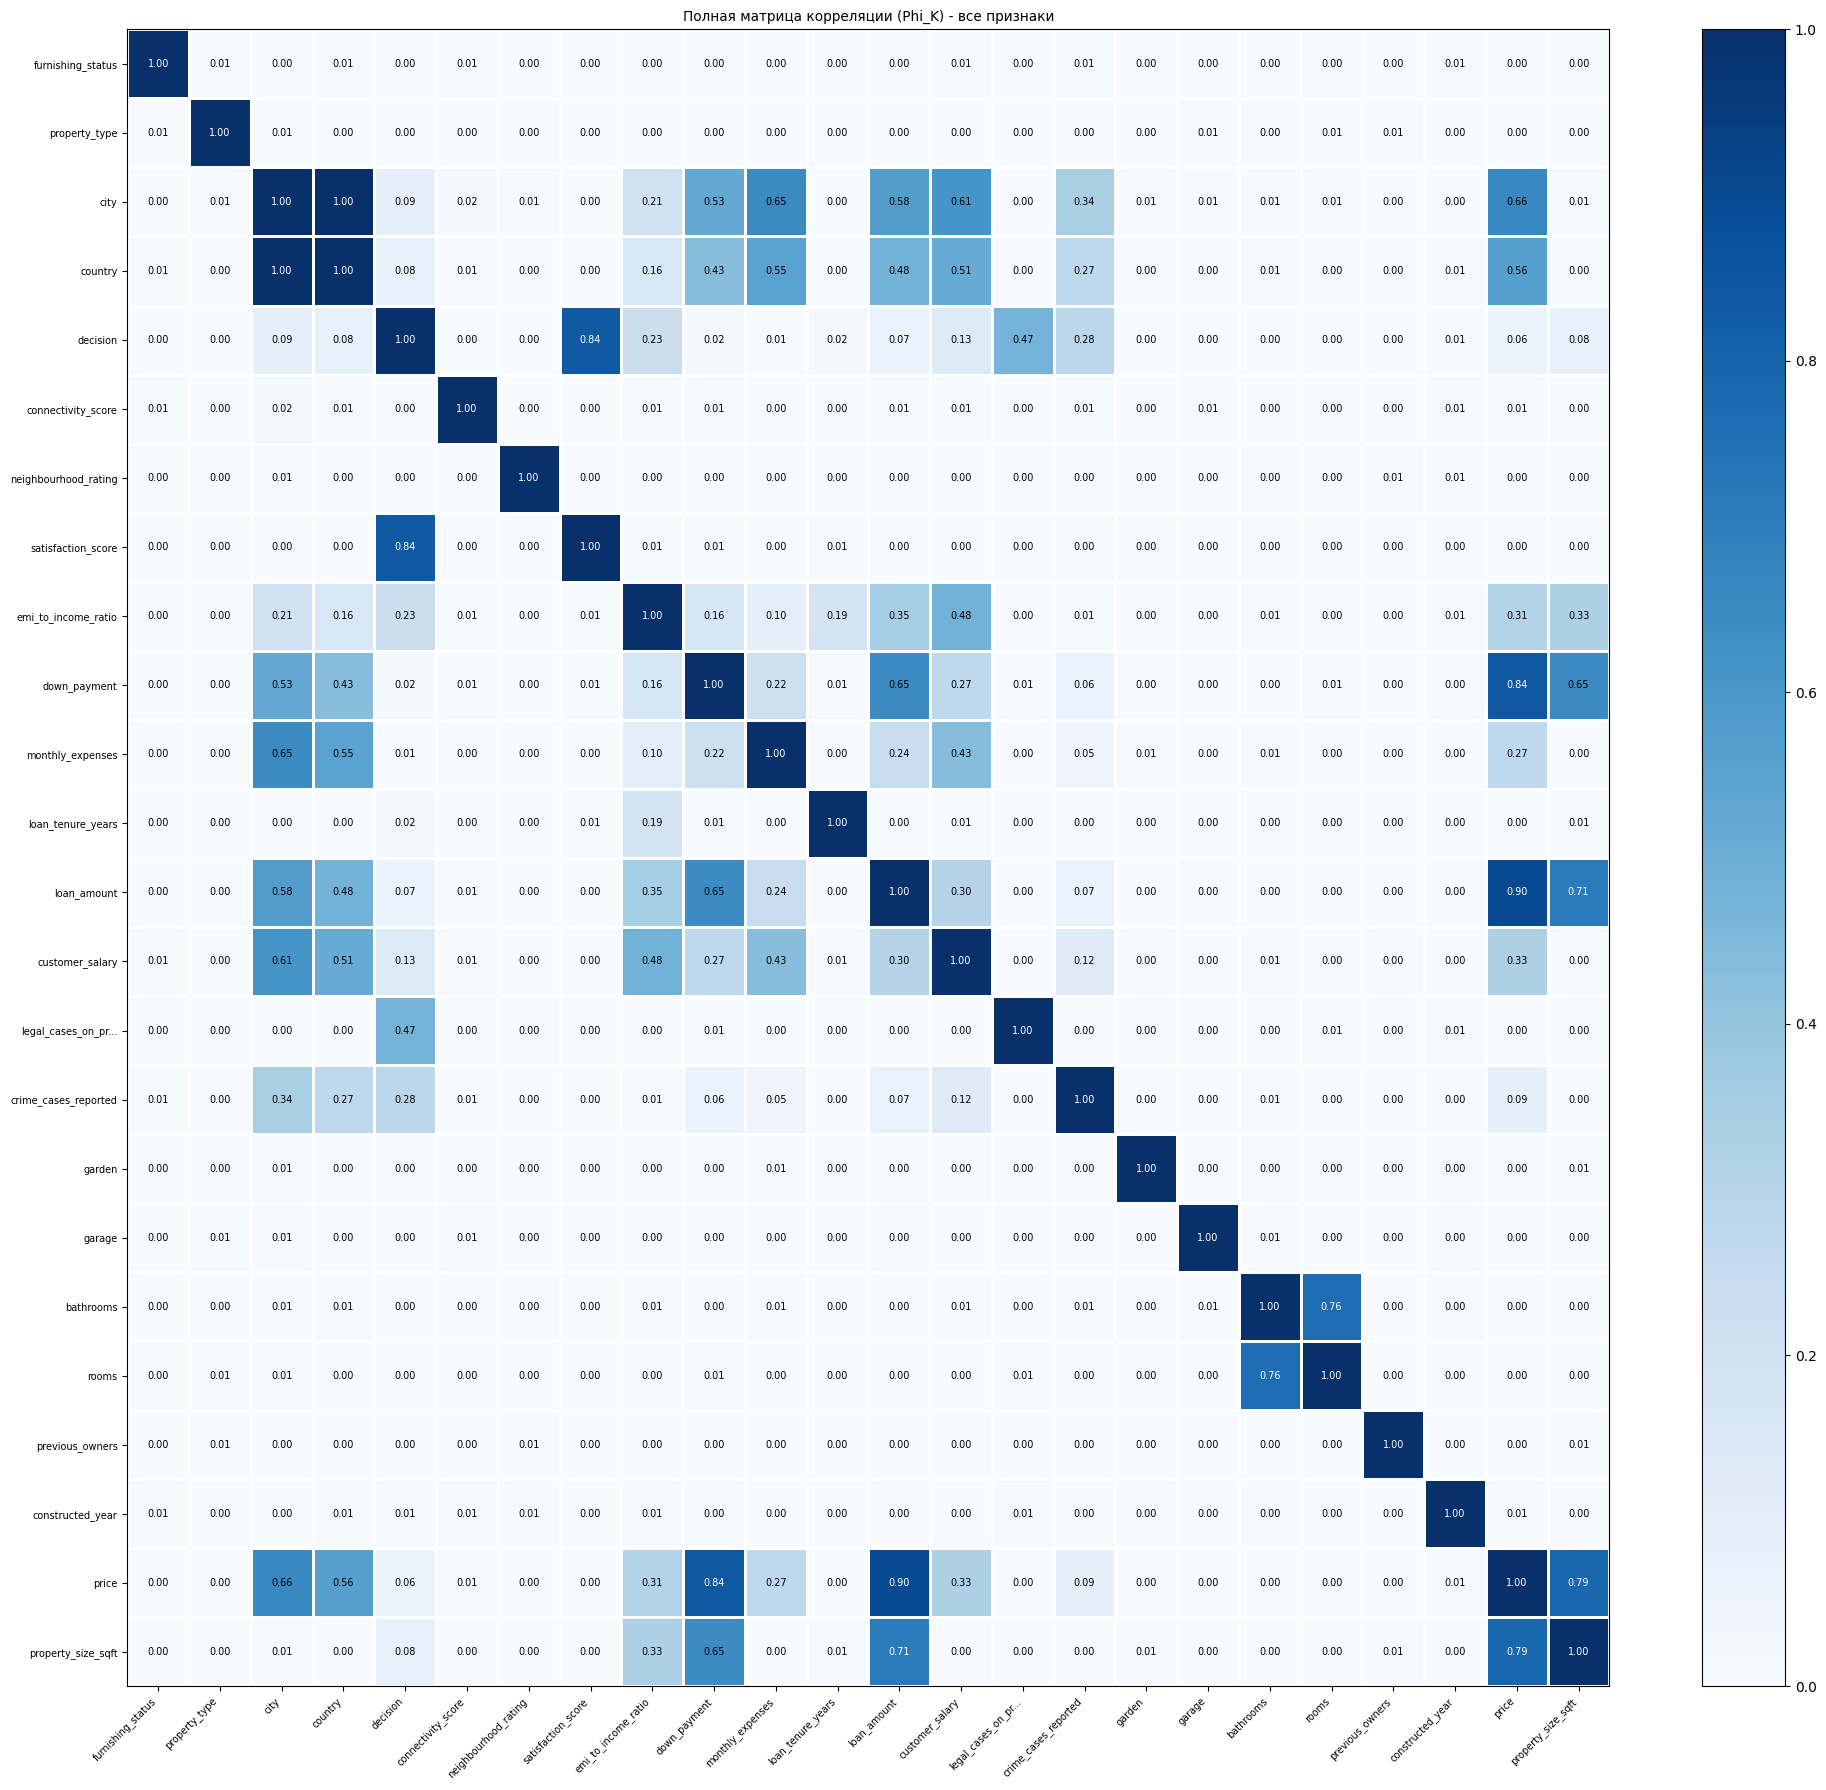

In [219]:
# Автоматически определяем числовые и категориальные признаки
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Объединяем все признаки
all_columns = numeric_columns + categorical_columns

# Создаем полную матрицу корреляции Phi_K со всеми признаками
phik_overview = df[all_columns].phik_matrix(interval_cols=numeric_columns)

# Визуализируем матрицу корреляции
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Полная матрица корреляции (Phi_K) - все признаки",
                        fontsize_factor=0.7,
                        figsize=(20, 18))
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [220]:
# Удаляем country из-за полной корреляции country и city, но city более информативная
df.drop(['country'], axis = 1, inplace = True)

# Удаляем признаки, слишком сильно коррелирующие с целевой переменной, чтобы избежать переобучения
df.drop(['satisfaction_score'], axis = 1, inplace = True)

In [221]:
# Берем decision как целевую переменную
target = df['decision']
features = df.drop(['decision'], axis=1)

In [222]:
# OneHot Encoding для категориальных признаков
categorical_features = ['property_type', 'furnishing_status']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(features[categorical_features])

In [223]:
# Проверка OneHot Encoding для категориальных признаков
print("\n", pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features)).head(10))


    property_type_Farmhouse  property_type_Independent House  \
0                      1.0                              0.0   
1                      0.0                              0.0   
2                      1.0                              0.0   
3                      1.0                              0.0   
4                      0.0                              0.0   
5                      0.0                              0.0   
6                      0.0                              0.0   
7                      0.0                              0.0   
8                      1.0                              0.0   
9                      0.0                              0.0   

   property_type_Studio  property_type_Townhouse  property_type_Villa  \
0                   0.0                      0.0                  0.0   
1                   0.0                      0.0                  0.0   
2                   0.0                      0.0                  0.0   
3           

In [224]:
# Объединяем числовые и закодированные категориальные признаки (кроме city)
numerical_features = [col for col in features.columns if col not in categorical_features + ['city']]
features_processed = pd.concat([
    features[numerical_features],
    pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))
], axis=1)

# Разделение выборки
features_train, features_valid, target_train, target_valid = \
    train_test_split(features_processed, target, test_size=0.2, random_state=42)

# Масштабирование признаков с помощью RobustScaler, так как в данных есть выбросы
robust_scaler = RobustScaler()
features_train_scaled = pd.DataFrame(
    robust_scaler.fit_transform(features_train),
    columns=features_train.columns,
    index=features_train.index
)
features_valid_scaled = pd.DataFrame(
    robust_scaler.transform(features_valid),
    columns=features_valid.columns,
    index=features_valid.index
)

In [225]:
# Теперь Frequency Encoding для city только на train данных
# Берем оригинальный city из разделенных данных
features_train_raw, features_valid_raw = train_test_split(features, test_size=0.2, random_state=42)

city_freq = features_train_raw['city'].value_counts(normalize=True).to_dict()
features_train['city_freq'] = features_train_raw['city'].map(city_freq)
features_valid['city_freq'] = features_valid_raw['city'].map(city_freq)

# Заполняем пропуски (если город в valid не был в train)
features_valid['city_freq'] = features_valid['city_freq'].fillna(0)

In [226]:
# Проверка на пропуски
print(f"Пропуски в данных: {features_processed.isnull().sum().sum()}")
print(f"Пропуски в target: {target.isnull().sum()}")

# Проверка разделения выборки
print(f"\nРазделение выборок:")
print(f"features_train: {features_train_scaled.shape}")
print(f"features_valid: {features_valid_scaled.shape}")
print(f"target_train: {target_train.shape}")
print(f"target_valid: {target_valid.shape}")

# Проверка распределения таргета
print("\nРаспределение таргета в выборках:")
print(f"Обучающая: {target_train.value_counts(normalize=True).values}")
print(f"Валидационная: {target_valid.value_counts(normalize=True).values}")

Пропуски в данных: 0
Пропуски в target: 0

Разделение выборок:
features_train: (160000, 25)
features_valid: (40000, 25)
target_train: (160000,)
target_valid: (40000,)

Распределение таргета в выборках:
Обучающая: [0.77045 0.22955]
Валидационная: [0.7665 0.2335]


In [227]:
best_params_et = {}
best_result_et = 0

for estimators in [30, 50, 100]:
    for depth in [5, 10, 15]:
        for min_samples_split in [15, 35, 50]:
            for min_samples_leaf in [10, 15, 25]:
                model_et = ExtraTreesClassifier(
                    random_state=42,
                    class_weight={0: 1, 1: 2.5},
                    n_estimators=estimators,
                    max_depth=depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    max_features=0.3,
                    bootstrap=True
                )
                model_et.fit(features_train_scaled, target_train)
                predictions_et = model_et.predict(features_valid_scaled)
                result_et = f1_score(target_valid, predictions_et)

                if result_et > best_result_et:
                    best_params_et = {
                        'n_estimators': estimators,
                        'max_depth': depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }
                    best_result_et = result_et
                    best_model_et = model_et

print('Лучшие параметры ExtraTrees:', best_params_et)
print('F1-score:', round(best_result_et, 4))

Лучшие параметры ExtraTrees: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 35, 'min_samples_leaf': 15}
F1-score: 0.5689


In [228]:
best_c_lsvc = 0
best_result_lsvc = 0

for c_value in [0.001, 0.005, 0.01, 0.05]:
    model_lsvc = LinearSVC(
        random_state=42,
        dual=False,
        class_weight={0: 1, 1: 2.5},
        C=c_value,
        max_iter=1000,
        tol=1e-4
    )
    model_lsvc.fit(features_train_scaled, target_train)
    predictions_lsvc = model_lsvc.predict(features_valid_scaled)
    result_lsvc = f1_score(target_valid, predictions_lsvc)

    if result_lsvc > best_result_lsvc:
        best_c_lsvc = c_value
        best_result_lsvc = result_lsvc
        best_model_lsvc = model_lsvc

print('F1 лучшей модели LinearSVC:', round(best_result_lsvc, 4))
print('Лучший параметр C:', best_c_lsvc)

F1 лучшей модели LinearSVC: 0.5265
Лучший параметр C: 0.05


In [229]:
# Предсказания лучших моделей
predictions_et_best = best_model_et.predict(features_valid_scaled)
predictions_lsvc_best = best_model_lsvc.predict(features_valid_scaled)

# Метрики лучших моделей
accuracy_et_best = accuracy_score(target_valid, predictions_et_best)
precision_et_best = precision_score(target_valid, predictions_et_best)
recall_et_best = recall_score(target_valid, predictions_et_best)
f1_et_best = f1_score(target_valid, predictions_et_best)

accuracy_lsvc_best = accuracy_score(target_valid, predictions_lsvc_best)
precision_lsvc_best = precision_score(target_valid, predictions_lsvc_best)
recall_lsvc_best = recall_score(target_valid, predictions_lsvc_best)
f1_lsvc_best = f1_score(target_valid, predictions_lsvc_best)

In [230]:
# Для ExtraTrees
print("ExtraTreesClassifier (лучшая модель):")
print(f"F1-Score: {f1_et_best}")
print(f"Precision: {precision_et_best}")
print(f"Recall: {recall_et_best}")
print(f"Accuracy: {accuracy_et_best}")

# Для LinearSVC
print("\nLinearSVC (лучшая модель):")
print(f"F1-Score: {f1_lsvc_best}")
print(f"Precision: {precision_lsvc_best}")
print(f"Recall: {recall_lsvc_best}")
print(f"Accuracy: {accuracy_lsvc_best}")

ExtraTreesClassifier (лучшая модель):
F1-Score: 0.5688883243895468
Precision: 0.404369611339322
Recall: 0.959100642398287
Accuracy: 0.660575

LinearSVC (лучшая модель):
F1-Score: 0.5264755980152559
Precision: 0.40241141175138684
Recall: 0.7611349036402569
Accuracy: 0.6803


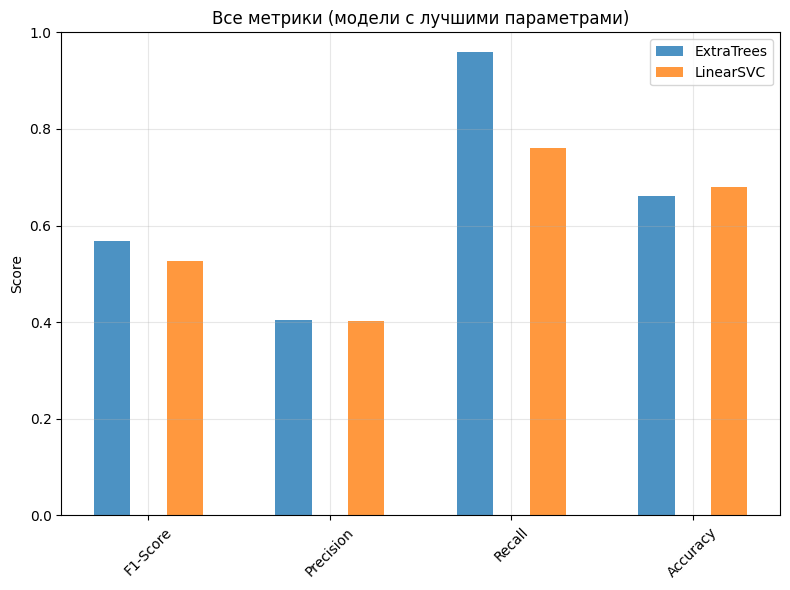

In [231]:
# Визуализация результатов по всем метрикам
plt.figure(figsize=(8, 6))

# Все метрики
all_metrics = ['F1-Score', 'Precision', 'Recall', 'Accuracy']
et_all = [f1_et_best, precision_et_best, recall_et_best, accuracy_et_best]
lsvc_all = [f1_lsvc_best, precision_lsvc_best, recall_lsvc_best, accuracy_lsvc_best]

x = range(len(all_metrics))
plt.bar([i - 0.2 for i in x], et_all, 0.2, label='ExtraTrees', alpha=0.8)
plt.bar([i + 0.2 for i in x], lsvc_all, 0.2, label='LinearSVC', alpha=0.8)

plt.ylabel('Score')
plt.title('Все метрики (модели с лучшими параметрами)')
plt.xticks(x, all_metrics, rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

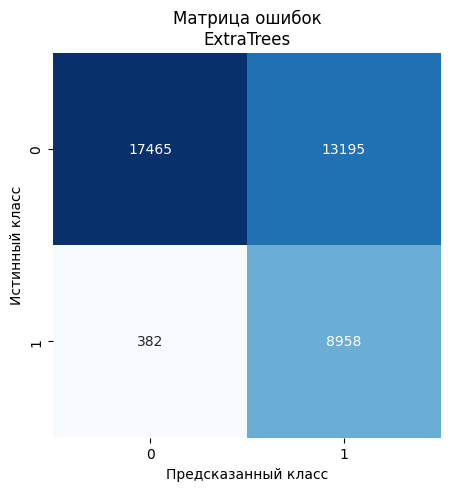

In [232]:
# Матрица ошибок для ExtraTrees
plt.figure(figsize=(5, 5))
cm_et_best = confusion_matrix(target_valid, predictions_et_best)
sns.heatmap(cm_et_best, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Матрица ошибок\nExtraTrees')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

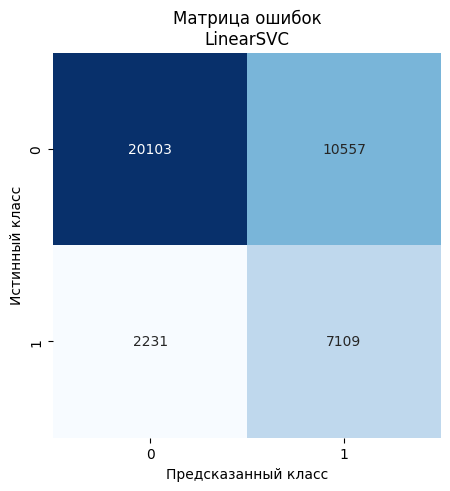

In [233]:
# Матрица ошибок для LinearSVC
plt.figure(figsize=(5, 5))
cm_lsvc_best = confusion_matrix(target_valid, predictions_lsvc_best)
sns.heatmap(cm_lsvc_best, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Матрица ошибок\nLinearSVC')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()